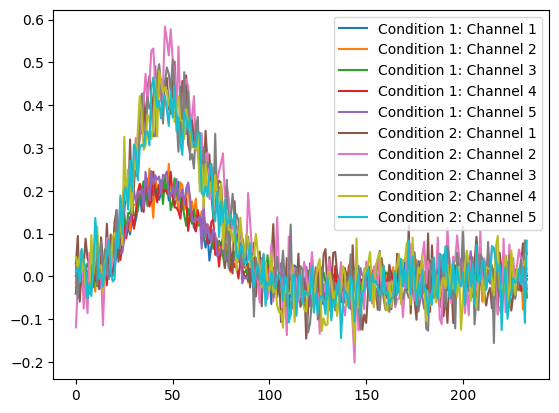

In [36]:
import numpy as np
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt
def gen_hrf(onset, amplitude, duration, time_length, sample_rate):
    exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
    frame_times = np.linspace(0, time_length, int(time_length * sample_rate), endpoint=False)
    signal, _labels = compute_regressor(exp_condition, "spm", frame_times, con_id="main", oversampling=16)
    return signal

def generate_multichannel_data(num_channels, time_length, sample_rate, onset, amplitude, duration, amplitude_ratio=0.1, signal_noise_ratio=0.1):
    channels_data = []
    for i in range(num_channels):
        
        # Introduce variability in amplitude for each channel
        if amplitude_ratio > 0:
            amplitude = amplitude + np.random.uniform(-amplitude_ratio*amplitude, amplitude_ratio*amplitude)
        signal = gen_hrf(onset, amplitude, duration, time_length, sample_rate)
        # Introduce noise
        if signal_noise_ratio > 0:
            range_amplitude = np.max(signal) - np.min(signal)
            noise = np.random.normal(0, range_amplitude * signal_noise_ratio, signal.shape)
            signal += noise
        channels_data.append(signal)
    channels_data = np.array(channels_data)
    return channels_data

# Parameters
time_length = 30.0
sample_rate = 7.8125
num_channels = 5  # Specify the number of channels

# Generate and plot multi-channel data
onset, amplitude, duration = 0.0, 1.0, 1.0
channels_data = generate_multichannel_data(num_channels, time_length, sample_rate, onset, amplitude, duration)
for i, channel_data in enumerate(channels_data):
    plt.plot(channel_data, label=f"Condition 1: Channel {i+1}")

onset, amplitude, duration = 0.0, 1.2, 1.5
channels_data = generate_multichannel_data(num_channels, time_length, sample_rate, onset, amplitude, duration)
for i, channel_data in enumerate(channels_data):
    plt.plot(channel_data, label=f"Condition 2: Channel {i+1}")
plt.legend()
plt.show()

In [57]:
import torch
import einops
import numpy as np



def gen_hrf(onset, amplitude, duration, time_length, sample_rate):
    exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
    frame_times = np.linspace(0, time_length, int(time_length * sample_rate), endpoint=False)
    signal, _labels = compute_regressor(exp_condition, "spm", frame_times, con_id="main", oversampling=16)
    return signal


class fNIRS_simulation_hrf(torch.utils.data.Dataset):
    def __init__(
            self, 
            num_channels = 20,
            time_length = 12,
            sample_rate = 7.8125,
            amplitude_ratio = 0.1,
            signal_noise_ratio = 0.1,
            num_conditions = 2,
            n_instances = 10000,
            dataset_random_state = 42,
            tier = 'train',
            sampler=None,
            pipeline=None,
            normalize_mode = 'normal',
            minmax_value = None,
            reversed = 0,
            amplitudes = [1.0, 1.2],
            onsets = [0.0, 0.0],
            durations = [1.0, 1.5],
            **kwargs
            ):
        self.__dict__.update(locals())
        self.setup()
        

        # self.pipeline = Compose(self.pipeline)
        # if self.sampler is not None:
        #     if "torchsampler" in self.sampler:
        #         import torchsampler
        #         self.data_sampler = getattr(torchsampler, self.sampler.replace("torchsampler.",""))(self)
        #     elif "imblearn.under_sampling" in self.sampler:
        #         import imblearn.under_sampling
        #         self.data_sampler = getattr(imblearn, self.sampler.replace("imblearn.under_sampling.",""))(self)
        #     else:
        #         self.data_sampler = getattr(torch.utils.data, self.sampler)(self)
        # else:
        #     self.data_sampler = torch.utils.data.RandomSampler(self)
    def setup(self):
        np.random.seed(self.dataset_random_state)
        pass

    def generate_multichannel_data(self, onset, amplitude, duration):
        # Pre-allocate array for efficiency
        channels_data = np.zeros((self.num_channels, int(self.time_length * self.sample_rate)))
        
        for i in range(self.num_channels):
            # Adjust amplitude with variability for each channel
            if self.amplitude_ratio > 0:
                amplitude *= (1 + np.random.uniform(-self.amplitude_ratio, self.amplitude_ratio))
            
            signal = gen_hrf(onset, amplitude, duration, self.time_length, self.sample_rate)
            
            # Add noise
            if self.signal_noise_ratio > 0:
                range_amplitude = np.ptp(signal)  # More efficient than max - min
                noise = np.random.normal(0, range_amplitude * self.signal_noise_ratio, signal.shape)
                signal += noise

            signal = signal = signal[:, 0]  
            channels_data[i, :] = signal
        
        return channels_data


    
    def __len__(self):
        return self.n_instances
    
    def __getitem__(self, idx):

        # random define condition
        condition = np.random.choice(self.num_conditions)
        onset = self.onsets[condition]
        amplitude = self.amplitudes[condition]
        duration = self.durations[condition]

        channels_data = self.generate_multichannel_data(onset, amplitude, duration)
        
        return {
            'seq': torch.tensor(channels_data, dtype=torch.float32),
        }, torch.tensor(condition, dtype=torch.long)
    

dataset = fNIRS_simulation_hrf()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=40, shuffle=True, num_workers=0)

for i, (data, label) in enumerate(dataloader):
    print(data['seq'].shape)
    print(label)
    break
        
                 

torch.Size([40, 20, 93])
tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0])
